In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split

from sklearn.datasets import load_digits


In [9]:
# This class plots the relevant raster plot of spikes and validation accuracy over time

class Spike_Plotter:
    def __init__(self):
        pass
     
    # Raster plot of spiking behavior for input and output neurons
    def Raster_Plot(self,input_data,output_data):
        
        def Convert_Data_To_Raster(data):
            result = []
            for i in range(len(data)):
                result.append([])
                for j in range(len(data[i])):
                    result[i].append(data[i][j]*j)
            return result
        
        # Set different colors for each neuron
        colorCodes = np.array([[0, 0, 0], [1, 0, 0], [0, 1, 0]])

        # Set spike colors for each neuron
        lineSize = [0.5, 0.5, 0.5]                                  

        # Draw a spike raster plot
        preparedData = input_data
        preparedData.append(np.array(output_data))
        neuralData = Convert_Data_To_Raster(preparedData)
        
        plt.yticks([0,1,2],['Input 1','Input 2','Output'])
        plt.eventplot(neuralData, color=colorCodes, linelengths=lineSize)     

        plt.title('Spike raster plot')
        plt.ylabel('Neuron')
        plt.xlabel('Time (msecs)')

        plt.show()

    # Plots validation accuracy over time
    def Validation_Plot(self, accuracies):
        plt.title('Validation Data Accuracy Per Training Iteration')
        plt.ylabel('Accuracy')
        plt.xlabel('Training Iteration')
        plt.plot(range(len(accuracies)), accuracies)
        plt.show()


In [10]:
# The Neuron Class manages all the parameters and models that are used for testing.  
# The class requires the models are first initialized by giving the model parameters before running
# Then the proper model's membrane potential function can be called for a given input current
# The returned voltage and spiking behavior across the duration of the current will be returned

#POTENTIAL_DECAY = 0.8
#CURRENT_DECAY = 0.8

#class Neuron:
#    def __init__(self):
#        self.LIF_initialilzed = False

#    def Initialize_LIF(self,neuron_resting_voltage,neuron_firing_threshold,C_m, R_m):
#        self.C_m = C_m
#        self.R_m = R_m
#        self.resting_voltage=neuron_resting_voltage
#        self.voltage_threshold=neuron_firing_threshold
#        self.LIF_initialized = True
        
#    def LIF_Neuron_Voltage_Current_Change(self,t,I, V_m, spike_trains, trained_weights,spike_occurrence_array):
#        if self.LIF_initialized:
#            I[t] = CURRENT_DECAY*I[t-1] + np.sum(spike_trains[:,t]*trained_weights)
#            if V_m[t-1] < self.voltage_threshold:
#                V_m[t] = POTENTIAL_DECAY*V_m[t-1] + I[t]
#                spike_occurrence_array[t-1] = 0
#            else:
#                V_m[t] = self.resting_voltage
#                spike_occurrence_array[t-1] = 1
#
#            return I, V_m
#        else:
#            raise Exception('LIF was not initialized')
#        
#    def LIF_Membrane_Potential(self,time, spike_trains, trained_weights):
#
#        spike_occurrence_array = np.zeros(time)
#        current_voltage = self.resting_voltage
#        V_m = np.zeros(time)
#        input_current = np.zeros(time)
#        for t in range(1,time):
#            input_current,V_m = self.LIF_Neuron_Voltage_Current_Change(t,input_current, \
#                                       V_m,spike_trains, trained_weights,spike_occurrence_array)
#
#        return input_current, V_m,spike_occurrence_array
        
    

In [11]:
# A simplified Leaky-Integrate-And-Fire Neuron designed for STDP
# Each neuron keeps track of the parameters used in the SNN construction so that they can be referred to
# The neuron tracks each of its fired spikes and the time between firings.
# The neuron also holds references to its presynaptic neurons and the weights of those connections

class Simplified_Neuron:
    def __init__(self,layer_number,parameters):
        self.parameters = parameters
        self.layer_number=layer_number
        
        self.t = 0
        self.spike_fired=[0]
        self.time_since_spike=[0]
        
        self.preset_spikes = False
        
        self.current_potential = self.parameters.resting_potential
        self.presynaptic_neurons = None
        self.weights = None
        
    # Updates the membrane potential of the neuron at each time step based on the incoming spikes of the presynaptic neurons

    def Update_Membrane_Potential(self):
        if not self.preset_spikes:
            spike_fired=0
            time_since_spike=self.time_since_spike[self.t]+1
            new_potential = self.parameters.resting_potential
            if self.parameters.minimum_potential<self.current_potential and self.current_potential < self.parameters.threshold_potential:
                incoming_spikes = self.Check_Presynaptic_Spikes()
                new_potential = self.current_potential+np.sum(incoming_spikes*self.weights)-self.parameters.delay
            elif self.parameters.threshold_potential <= self.current_potential:
                spike_fired=1
                time_since_spike=0
                new_potential = self.parameters.resting_potential
            elif self.current_potential <= self.parameters.minimum_potential:
                new_potential = self.parameters.resting_potential
            
            self.current_potential = new_potential
            self.spike_fired.append(spike_fired)
            self.time_since_spike.append(time_since_spike)
        self.t+=1
    
    # Obtains the calculations for updating the weights and updates all the weights to the presynaptic neurons
    
    #def Update_Weights(self):
    #    for i in range(len(self.presynaptic_neurons)):
    #        new_weight=self.New_Weight(self.presynaptic_neurons[i],self.weights[i])
    #        self.weights[i]=new_weight
    
    # Sets a series of preset input spikes to represent training data
    
    def Input_Spikes(self,spike_train):
        self.spike_fired = spike_train
        time_since_spike=0
        time_since_spike_array = [0]
        for i in range(1,len(spike_train)):
            if spike_train[i]==1:
                time_since_spike_array.append(0)
            else:
                time_since_spike_array.append(time_since_spike_array[i-1]+1)
        self.time_since_spike = time_since_spike_array
        self.preset_spikes = True
        
    # Resets the membrane potential of the neuron
        
    def Reset(self):
        self.t = 0
        self.spike_fired = [0]
        self.time_since_spike = [0]
        self.current_potential = self.parameters.resting_potential
        
    # Resets the neuron to default after using the training spike information
    def Complete_Training(self):
        self.Reset()
        self.preset_spikes = False
    
    # Determines if the presynaptic neurons have spiked
    def Check_Presynaptic_Spikes(self):
        spikes = []
        for neuron in self.presynaptic_neurons:
            spikes.append(neuron.Check_If_Spike_Fired())
        return np.array(spikes)
    
    # Returns if the array of all neuron spikes up to the current moment
    def Get_Spikes(self):
        return self.spike_fired
    
    # Checks if the neuron has spiked at the current time
    def Check_If_Spike_Fired(self):
        return self.spike_fired[self.t]
    
    # Checks how long it has been since the neuron has spiked
    def Get_Time_Since_Spike(self):
        return self.time_since_spike[self.t]
    
    # Updates the references to all the presynaptic layer neurons and generates initial weights
    def Set_Presynaptic_Neurons(self,presynaptic_neurons):
        self.presynaptic_neurons = presynaptic_neurons
        weights = []
        
        initial_weights=np.random.uniform(self.parameters.w_min,self.parameters.w_max,len(presynaptic_neurons))
        for i in range(len(presynaptic_neurons)):
            #weights.append(initial_weights[i])
            weights.append(0.5)
        self.weights = np.array(weights)
    
    # Recursive propagation through the layers of the network updating the weights
    def Recursive_Weight_Updates(self):
        if self.presynaptic_neurons is not None and self.t<len(self.spike_fired):
            for i in range(len(self.presynaptic_neurons)):
                neuron = self.presynaptic_neurons[i]
                neuron.Recursive_Weight_Updates()
                self.weights[i]=self.New_Weight(neuron,self.weights[i])
    
    # Recursive propagation through the layers of the network updating each neurons spiking potential
    def Recursive_Spike_Propagation(self):
        if self.presynaptic_neurons is not None:
            for i in range(len(self.presynaptic_neurons)):
                neuron = self.presynaptic_neurons[i]
                neuron.Recursive_Spike_Propagation()
            self.Update_Membrane_Potential()
        
    # Gets the time difference between the latest post-synaptic and pre-synaptic spike
    def Get_Delta_T(self,presynaptic_neuron):
        presynaptic_spike=presynaptic_neuron.Check_If_Spike_Fired()
        presynaptic_t = presynaptic_neuron.Get_Time_Since_Spike()
        if presynaptic_spike==1 or self.spike_fired[self.t]==1:
            delta_t=presynaptic_t - self.time_since_spike[self.t]
        else:
            delta_t=0
        return delta_t
        
    # Determines the change in the weight based on the time difference between spikes
    def Get_Delta_Weight(self,presynaptic_neuron):
        delta_t=self.Get_Delta_T(presynaptic_neuron)
        delta_weight=0
        if delta_t<=-2:
            delta_weight=self.parameters.A_minus*np.exp(delta_t/self.parameters.tau_minus)
        elif delta_t>=2:
            delta_weight=self.parameters.A_plus*np.exp(delta_t/self.parameters.tau_plus)
        return delta_weight
    
    # Determines the new weight value of each synaptic connection
    def New_Weight(self,presynaptic_neuron,old_weight):
        delta_weight=self.Get_Delta_Weight(presynaptic_neuron)
        new_weight=old_weight
        if delta_weight>0:
            new_weight = old_weight + self.parameters.learning_rate*delta_weight*(self.parameters.w_max-old_weight)
        elif delta_weight<=0:
            new_weight = old_weight + self.parameters.learning_rate*delta_weight*(old_weight-self.parameters.w_min)
        return new_weight


In [12]:
# Class holds onto all the relevant parameter information of the Spiking Neural Network
# so that it can be referenced by other classes

class Network_Parameters:
     def __init__(self,learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min):
        self.threshold_potential = threshold_potential
        self.resting_potential = resting_potential
        self.minimum_potential = minimum_potential
        self.delay = delay
        self.learning_rate = learning_rate
        self.A_minus=A_minus
        self.A_plus=A_plus
        self.tau_minus=tau_minus
        self.tau_plus=tau_plus
        self.w_max = w_max
        self.w_min = w_min

# The STDP Spiking Neural Network that holds the neuron layers
# The class initiates updates to weights and membrane potentials

class Spiking_Neural_Network:
    def __init__(self,num_of_input_neurons,parameters):
        self.parameters=parameters
        self.input_neurons = []
        self.output_neurons = []
        for i in range(num_of_input_neurons):
            neuron=Simplified_Neuron(1,self.parameters)
            self.input_neurons.append(neuron)
            self.output_neurons.append(neuron)
        self.num_of_layers = 1
        
    # Adds a new layer of neurons to the network and makes that layer the new output layer
    def Add_New_Layer(self,num_of_neurons):
        self.num_of_layers+=1
        new_output_neurons = []
        for i in range(num_of_neurons):
            neuron=Simplified_Neuron(self.num_of_layers,self.parameters)
            neuron.Set_Presynaptic_Neurons(self.output_neurons)
            new_output_neurons.append(neuron)
        self.output_neurons=new_output_neurons
        
    # Recursively moves through the layers updating all the weights
    def Update_Network_Weights(self):
        for neuron in self.output_neurons:
            neuron.Recursive_Weight_Updates()
            
    # Recursively moves through the layers updating all the spiking potentials
    def Update_Membrane_Potential(self):
        for neuron in self.output_neurons:
            neuron.Recursive_Spike_Propagation()
            
# A network manager that holds onto the SNN as well as it's relevant parameters
# Manages the training and testing of the network itself

class Spiking_Neural_Network_Manager:
    def __init__(self):
        self.parameters_established = False
        self.network_established = False
    
    def Establish_Parameters(self,learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min):
        self.parameters = Network_Parameters(learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min)
        self.parameters_established = True
        
    def Establish_Network(self,num_of_inputs):
        if self.parameters_established:
            self.network=Spiking_Neural_Network(num_of_inputs,self.parameters)
            self.network_established = True
            
    def Add_New_Layer(self,num_of_neurons):
        if self.network_established:
            self.network.Add_New_Layer(num_of_neurons)
            
    # Sets all the input and output neurons to use preset input spikes for training
    def Prepare_To_Train(self,x,y):
        for i in range(len(self.network.input_neurons)):
            self.network.input_neurons[i].Input_Spikes(x[i])
        for i in range(len(self.network.output_neurons)):
            self.network.output_neurons[i].Input_Spikes(y[i])
            
    # Resets the neurons to initial time state
    def Reset(self):
        for neuron in self.network.input_neurons:
            neuron.Reset()
        for neuron in self.network.output_neurons:
            neuron.Reset()
        
    # Completely resets the neuron to default
    def Complete_Training(self):
        for neuron in self.network.input_neurons:
            neuron.Complete_Training()
        for neuron in self.network.output_neurons:
            neuron.Complete_Training()
    
    # Sets all the input neurons to use preset input spikes for testing
    def Prepare_To_Test(self,x):
        for i in range(len(self.network.input_neurons)):
            self.network.input_neurons[i].Input_Spikes(x[i])
    
    # Trains the network using the preset input data x and output data y
    def Train(self,x,y):
        if self.network_established:
            self.Prepare_To_Train(x,y)
            
            for j in range(100):
                for i in range(len(x[0])):
                    self.network.Update_Membrane_Potential()
                    self.network.Update_Network_Weights()
                self.Reset()
            self.Complete_Training()
            print(self.network.output_neurons[0].weights)
    
    # Trains the network using the preset input data x and output data y
    # After each training iteration, tests the network on the validation data and records the accuracy
    
    def Validation_Train(self,x,y,validation_x,validation_y):
        if self.network_established:
            self.Prepare_To_Train(x,y)
            
            validation_accuracy = []
            
            for j in range(100):
                for i in range(len(x[0])):
                    self.network.Update_Membrane_Potential()
                    self.network.Update_Network_Weights()
                self.Complete_Training()
                result=self.Test(validation_x,validation_y)
                validation_accuracy.append(result)
                
            return validation_accuracy
                
    # Tests the network on the preset input data x and records the output
    def Test(self,x):

        if self.network_established:
            self.Prepare_To_Test(x)
            
            for i in range(len(x[0])):
                self.network.Update_Membrane_Potential()
            
            result=[]
            for neuron in self.network.output_neurons:
                result.append(neuron.Get_Spikes())
            self.Reset()
                
            return result
                
            
    

In [13]:
# Manages the encoding and decoding of the data into spike trains that can be input into the network
# Records a goal spiking rate per second and how many milliseconds to generate data for
class Data:
    def __init__(self, spikes_per_second,T):
        self.spikes_rate=spikes_per_second
        self.T=T

    
    # Generate Spike Train From a given binary value
    def Encode(self,data_value):
        if data_value==1:
            multiplier=3
        elif data_value==0:
            multiplier=1
        rate = float(multiplier*self.spikes_rate) / self.T
        spike_trains=np.random.binomial(size=self.T,n=1,p=rate)
        return spike_trains
    
    # Decodes the binary value from a given spike train
    def Decode(self,spike_train):
        spike_count = np.sum(spike_train)
        spike_rate = float(spike_count)/self.T
        value = float(spike_rate) * self.spikes_rate
        return spike_count
    
    
    
    #Generates spike trains for boolean logic gate inputs 1-1,1-0,0-1,0-0
    def gate_input_values(self):
        x1 = np.concatenate((self.Encode(1),self.Encode(1),self.Encode(0),self.Encode(0)))
        x2 = np.concatenate((self.Encode(1),self.Encode(0),self.Encode(1),self.Encode(0)))
        
        x=[x1,x2]
        return x
        
    def simple_and_gate(self):
        x1 = self.Encode(1)
        x2 = self.Encode(0)
        y = self.Encode(0)
        x=[x1,x2]
        return x,y
        
    # Generates the spike trains of input and output of a boolean 'AND' gate
    def and_gate(self):
        x = self.input_values()
        y = [np.concatenate((self.Encode(1),self.Encode(0),self.Encode(0),self.Encode(0)))]
        return x,y
        
    # Generates the spike trains of input and output of a boolean 'OR' gate
    def or_gate(self,spike_trains):
        x = self.input_values()
        y = [np.concatenate((self.Encode(1),self.Encode(1),self.Encode(1),self.Encode(0)))]
        return x,y

    # Generates the spike trains of input and output of a boolean 'XOR' gate
    def xor_gate(self,spike_trains):
        x = self.input_values()
        y = [np.concatenate((self.Encode(0),self.Encode(1),self.Encode(1),self.Encode(0)))]
        return x,y

    # Switch for determining which data to generate
    def Generate_Data(self,gate):
        if gate=='AND':
            x,y=self.and_gate()
        elif gate=='OR':
            x,y=self.or_gate()
        elif gate=='XOR':
            x,y=self.xor_gate()
        elif gate=='SIMPLE':
            x,y=self.simple_and_gate()
        return x,y

# Generates the digit class data
class Digit_Data:
    def __init__(self,spikes_per_second,T):
        self.train_ratio = 0.75
        self.validation_ratio = 0.15
        self.test_ratio = 0.10
        self.threshold_intensity = 0.035
        self.spikes_rate=spikes_per_second
        self.T=T
        self.output_intensity = 1
    
    # Obtains the dataset and splits into train, validation and test sets
    def generate_data(self):
        digits,values  = load_digits()['images'],load_digits()['target']
        train_data,test_data,train_values,test_values = train_test_split(digits,values,test_size=1-self.train_ratio)
        test_data,validation_data,test_values,validation_values = \
                        train_test_split(test_data,test_values, test_size = self.test_ratio/(self.test_ratio+self.validation_ratio))
        return (train_data,train_values), (test_data,test_values), (validation_data,validation_values)
    
    # Converts to spike trains
    def get_spike_train(self,data_value):
        if data_value==1:
            multiplier=3
        elif data_value==0:
            multiplier=1
        rate = float(multiplier*self.spikes_rate) / self.T
        spike_trains=np.random.binomial(size=self.T,n=1,p=rate)
        return spike_trains
    
    # Decods the spike trains
    def Decode(self,spike_train):
        spike_count = np.sum(spike_train)
        spike_rate = float(spike_count)/self.T
        value = float(spike_rate) * self.spikes_rate
        return spike_count
    
    # Encodes each pixel into a spike train by determining if the pixel passes a given threshold intensity
    def encode(self,data,output):
        data = np.concatenate(data).ravel()
        data = data / np.sum(data)

        for j in range(len(data)):
            if data[j] >= self.threshold_intensity:
                data[j] = 1
            else:
                data[j] = 0
        new_data = []
        for j in range(len(data)):
            new_data.append(self.get_spike_train(data[j]))
        y = []
        for i in range(10):
            if i == output:
                y.append(self.get_spike_train(1))
            else:
                y.append(self.get_spike_train(0))
        
        return np.asarray(new_data), y

Data Established
Network Constructed
[0.5 0.5]
Training Complete
Y's value is 0
Y's value is 0
Y's value is 0
Y's value is 0


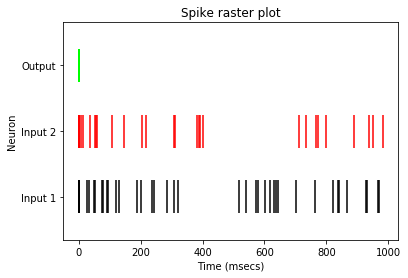

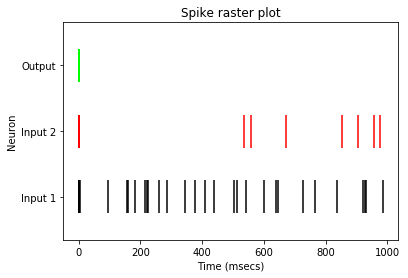

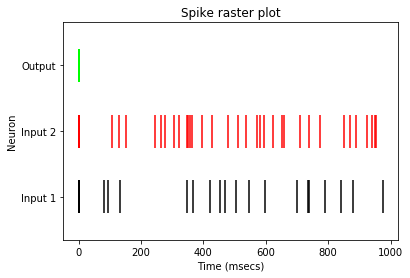

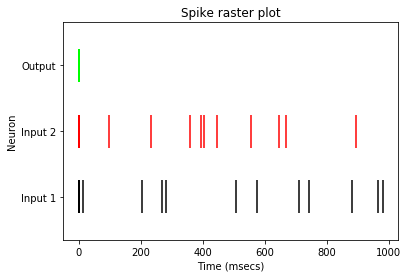

In [14]:


def Gate_Test():
    learning_rate=0.1
    minimum_potential=-0.3
    threshold_potential=10
    resting_potential=0
    delay=0
    A_minus=0.3
    A_plus=0.8
    tau_minus=5
    tau_plus=8
    w_max=0
    w_min=1

    plotter=Spike_Plotter()

    spikes_per_second=10
    T=1000
    data=Data(spikes_per_second,T)
    print("Data Established")

    network=Spiking_Neural_Network_Manager()
    network.Establish_Parameters(learning_rate,minimum_potential,threshold_potential,resting_potential,delay,A_minus,A_plus,tau_minus,tau_plus,w_max,w_min)
    network.Establish_Network(2)
    network.Add_New_Layer(1)
    print("Network Constructed")

    x,y=data.Generate_Data('AND')
    network.Train(x,y)
    print("Training Complete")

    x_1_1=[data.Encode(1),data.Encode(1)]
    x_1_0=[data.Encode(1),data.Encode(0)]
    x_0_1=[data.Encode(0),data.Encode(1)]
    x_0_0=[data.Encode(0),data.Encode(0)]

    y_1_1=network.Test(x_1_1)
    print("Y's value is "+str(data.Decode(y_1_1[0])))
    plotter.Raster_Plot(title,x_1_1,y_1_1[0][:1000])

    y_1_0=network.Test(x_1_0)
    print("Y's value is "+str(data.Decode(y_1_0[0])))
    plotter.Raster_Plot(title,x_1_0,y_1_0[0][:1000])
    
    y_0_1=network.Test(x_0_1)
    print("Y's value is "+str(data.Decode(y_0_1[0])))
    plotter.Raster_Plot(title,x_0_1,y_0_1[0][:1000])

    y_0_0=network.Test(x_0_0)
    print("Y's value is "+str(data.Decode(y_0_0[0])))
    plotter.Raster_Plot(title,x_0_0,y_0_0[0][:1000])

    
def Digit_Test():
    digit_data = Digit_Data()
    (train_data,train_values),(test_data,test_values),(validation_data,validation_values) = digit_data.generate_data()
    print(train_data)
    print(train_values)


Gate_Test()